In [1]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
import importlib
import galaxy

In [2]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [41]:
def get_stellar_mass(sn):
    if sn.NumPart_Total[4] == 0:
        return 0.0

    return np.sum(sn.part4.mass.value[sn.part4.GFM_StellarFormationTime > 0])

def weighted_median(values, weights):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, 0.5 * c[-1])]]

def get_halfmass_radius(sn):
    center = sn.part1.pos.value[np.argmin(sn.part1.pot)]
    
    if sn.NumPart_Total[4] == 0:
        return np.nan
    
    pos = sn.part4.pos.value - center
    mass = sn.part4.mass.value
    r = np.linalg.norm(pos, axis=1)
    
    is_star = sn.part4.GFM_StellarFormationTime > 0
    if np.sum(is_star) <= 1:
        return np.nan
    
    rhalf = weighted_median(r[is_star], mass[is_star])
    
    return rhalf

In [113]:
sfr = {}
sfr['MW8iso_lvl5']   = np.genfromtxt(basepath + 'runs/MW8iso/lvl5/output/sfr.txt')
sfr['MW8iso_vp01_lvl5']   = np.genfromtxt(basepath + 'runs/MW8iso/lvl5-vp01/output/sfr.txt')
sfr['MW8iso_fb025vp01_lvl5']   = np.genfromtxt(basepath + 'runs/MW8iso/lvl5-fb025-vp01/output/sfr.txt')
sfr['MW8iso_fb022vp01_lvl5']   = np.genfromtxt(basepath + 'runs/MW8iso/lvl5-fb022-vp01/output/sfr.txt')
sfr['MW8iso_fb024vp015_lvl5']   = np.genfromtxt(basepath + 'runs/MW8iso/lvl5-fb024-vp015/output/sfr.txt')

sfr['GSE4iso_fb02_lvl5'] = np.genfromtxt(basepath + 'runs/GSE4iso/lvl5-fb02-newsoft/output/sfr.txt')
sfr['GSE4iso_fb016vp02_lvl5'] = np.genfromtxt(basepath + 'runs/GSE4iso/lvl5-fb016-vp02-newsoft/output/sfr.txt')
sfr['GSE4iso_fb01vp01_lvl5'] = np.genfromtxt(basepath + 'runs/GSE4iso/lvl5-fb01-vp01-newsoft/output/sfr.txt')
sfr['GSE4iso_fb008vp008_lvl5'] = np.genfromtxt(basepath + 'runs/GSE4iso/lvl5-fb008-vp008-newsoft/output/sfr.txt')
sfr['GSE4iso_fb009vp009_lvl5'] = np.genfromtxt(basepath + 'runs/GSE4iso/lvl5-fb009-vp009-newsoft/output/sfr.txt')
sfr['GSE4iso_fb009vp01_lvl5'] = np.genfromtxt(basepath + 'runs/GSE4iso/lvl5-fb009-vp01-newsoft/output/sfr.txt')

(0.0, 6.9054972)

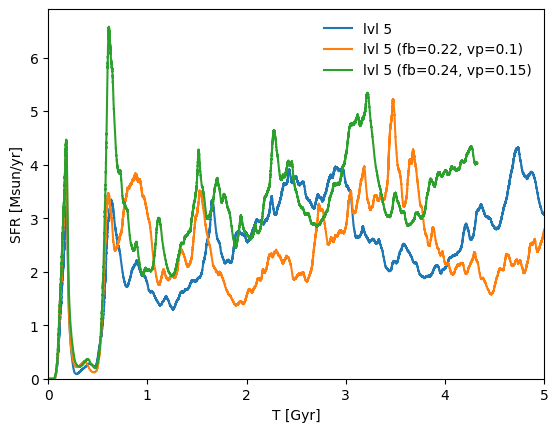

In [78]:
plt.plot(sfr['MW8iso_lvl5'][:,0], sfr['MW8iso_lvl5'][:,2], label='lvl 5')
# plt.plot(sfr['MW8iso_vp01_lvl5'][:,0], sfr['MW8iso_vp01_lvl5'][:,2], label='lvl 5 (vp=0.1)')
# plt.plot(sfr['MW8iso_fb025vp01_lvl5'][:,0], sfr['MW8iso_fb025vp01_lvl5'][:,2], label='lvl 5 (fb=0.25, vp=0.1)')
plt.plot(sfr['MW8iso_fb022vp01_lvl5'][:,0], sfr['MW8iso_fb022vp01_lvl5'][:,2], label='lvl 5 (fb=0.22, vp=0.1)')
plt.plot(sfr['MW8iso_fb024vp015_lvl5'][:,0], sfr['MW8iso_fb024vp015_lvl5'][:,2], label='lvl 5 (fb=0.24, vp=0.15)')
plt.legend(frameon=False)

plt.xlim(0, 5)
plt.xlabel('T [Gyr]')
plt.ylabel('SFR [Msun/yr]')

plt.ylim(0, None)

(0.0, 1.6583217)

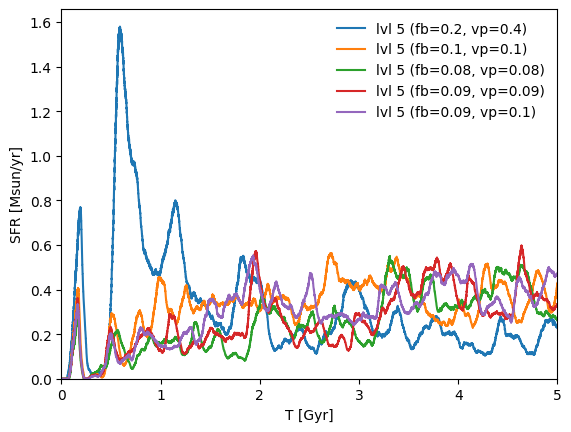

In [114]:
plt.plot(sfr['GSE4iso_fb02_lvl5'][:,0], sfr['GSE4iso_fb02_lvl5'][:,2], label='lvl 5 (fb=0.2, vp=0.4)')
# plt.plot(sfr['GSE4iso_fb016vp02_lvl5'][:,0], sfr['GSE4iso_fb016vp02_lvl5'][:,2], label='lvl 5 (fb=0.16, vp=0.2)')
plt.plot(sfr['GSE4iso_fb01vp01_lvl5'][:,0], sfr['GSE4iso_fb01vp01_lvl5'][:,2], label='lvl 5 (fb=0.1, vp=0.1)')
plt.plot(sfr['GSE4iso_fb008vp008_lvl5'][:,0], sfr['GSE4iso_fb008vp008_lvl5'][:,2], label='lvl 5 (fb=0.08, vp=0.08)')
plt.plot(sfr['GSE4iso_fb009vp009_lvl5'][:,0], sfr['GSE4iso_fb009vp009_lvl5'][:,2], label='lvl 5 (fb=0.09, vp=0.09)')
plt.plot(sfr['GSE4iso_fb009vp01_lvl5'][:,0], sfr['GSE4iso_fb009vp01_lvl5'][:,2], label='lvl 5 (fb=0.09, vp=0.1)')
plt.legend(frameon=False)

plt.xlim(0, 5)
plt.xlabel('T [Gyr]')
plt.ylabel('SFR [Msun/yr]')

plt.ylim(0, None)

In [110]:
sn120_MWiso = arepo.Snapshot(basepath + 'runs/MW8iso/lvl5-fb024-vp015/output', 120)
sn120_GSEiso2 = arepo.Snapshot(basepath + 'runs/GSE4iso/lvl5-fb009-vp009-newsoft/output', 120)
sn120_GSEiso = arepo.Snapshot(basepath + 'runs/GSE4iso/lvl5-fb009-vp01-newsoft/output', 120)

In [111]:
print('stellar mass at 3 Gyr [1E10 Msun]')
print('MWiso:', get_stellar_mass(sn120_MWiso))
print('GSEiso:', get_stellar_mass(sn120_GSEiso))
print('GSEiso 2:', get_stellar_mass(sn120_GSEiso2))

stellar mass at 3 Gyr [1E10 Msun]
MWiso: 0.5582472
GSEiso: 0.049226616
GSEiso 2: 0.03781978


In [112]:
print('half mass radius at 3 Gyr [kpc]')
print('MWiso:', get_halfmass_radius(sn120_MWiso))
print('GSEiso:', get_halfmass_radius(sn120_GSEiso))
print('GSEiso 2:', get_halfmass_radius(sn120_GSEiso2))

half mass radius at 3 Gyr [kpc]
MWiso: 3.8447940424978375
GSEiso: 2.8017603804394704
GSEiso 2: 1.7746659323482563


In [102]:
# milky way heavier and bigger
# GSE lighter and smaller

In [ ]:
sn120_MWiso = arepo.Snapshot(basepath + 'runs/MW8iso/lvl5-fb025-vp01/output', 120)
sn120_GSEiso = arepo.Snapshot(basepath + 'runs/GSE4iso/lvl5-fb016-vp02-newsoft/output', 120)

In [52]:
sn = arepo.Snapshot(basepath + 'runs/GSE4iso/lvl5-newsoft/output', 120)
print('fb=0.06, M at 3 Gyr: ', round(get_stellar_mass(sn), 5), ', size at 3 Gyr:', round(get_halfmass_radius(sn), 4))

sn = arepo.Snapshot(basepath + 'runs/GSE4iso/lvl5-fb02-newsoft/output', 120)
print('fb=0.20, M at 3 Gyr: ', round(get_stellar_mass(sn), 5), ', size at 3 Gyr:', round(get_halfmass_radius(sn), 4))

sn = arepo.Snapshot(basepath + 'runs/GSE4iso/lvl5-fb016-vp02-newsoft/output', 120)
print('fb=0.16, M at 3 Gyr: ', round(get_stellar_mass(sn), 5), ', size at 3 Gyr:', round(get_halfmass_radius(sn), 4))

fb=0.06, M at 3 Gyr:  0.00488 , size at 3 Gyr: 4.6346
fb=0.20, M at 3 Gyr:  0.07905 , size at 3 Gyr: 7.2071
fb=0.16, M at 3 Gyr:  0.09266 , size at 3 Gyr: 5.0631


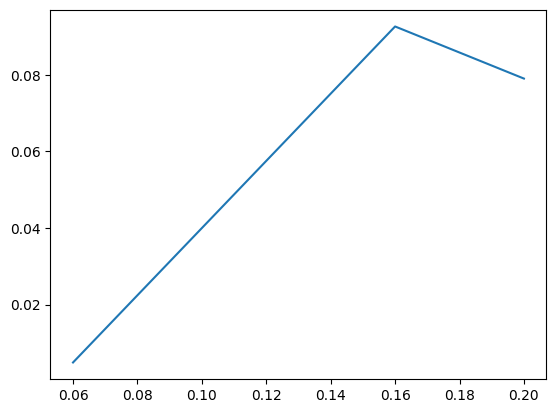

In [53]:
x = [0.06, 0.16, 0.20]
y = [0.00488, 0.09266, 0.07905]
plt.plot(x, y)

## Rising From the Ashes: How the Milky Way got its Scars

Stars inherit the nuclear abundance of the gas from which they form. For the most part, stars do not change their surface abundances over time, and so the present day stellar abundances encode snapshots of the gas-phase metallicity of the Milky Way. Much attention has been paid to a relative dearth of stars at a particular ratio of alpha-process elements to iron (the so-called alpha bimodality). In this work, we propose the phoenix hypothesis: the bimodality is caused by a starburst followed by a brief quiescent phase. The starburst allows for many low-mass Type II supernovae to concurrently enrich the Galaxy in iron with relatively little alpha enrichment. This enrichment occurs during the quiescent phase, when no new stars are formed, naturally leading to the valley between the high- and low-alpha sequences. This phoenix phase could be triggered by the Gaia-Sausage-Enceladus merger, but our hypothesis does not necessitate it. With a range of idealized simulations, we demonstrate the plausibility of this scenario.